In [2]:
import torch
from torch import nn
import torchvision as tv
from torch.utils.data import DataLoader
import time
import os

In [3]:
from torchvision import models

In [4]:
import copy

In [29]:
import PIL

## Загрузка данных

In [5]:
data_transforms = {
    "train": tv.transforms.Compose([
        tv.transforms.Resize(256),
        tv.transforms.CenterCrop(224),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": tv.transforms.Compose([
        tv.transforms.Resize(256),
        tv.transforms.CenterCrop(224),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [6]:
data_dir = 'input\hymenoptera_data\hymenoptera_data'
image_datasets = {x: tv.datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

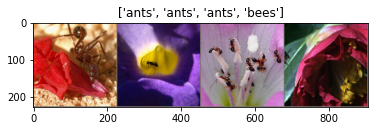

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


inputs, classes = next(iter(dataloaders['train']))
out = tv.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Обучение сети

In [7]:
def train_model(model, criterion, optimizer, dataloader, device, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                     if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, best_acc

## модель VGG-16 обученная с нуля

In [8]:
model_vgg16 = models.vgg16(pretrained=False)

In [9]:
num_ftrs = model_vgg16.classifier[6].in_features
model_vgg16.classifier[6]= nn.Linear(num_ftrs, 2)
model_vgg16 = model_vgg16.to('cpu')

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(model_vgg16.parameters(), lr=0.001, momentum=0.9)
model_vgg16, vgg16_clean_acc = train_model(model_vgg16, criterion, optimizer_ft, dataloaders, device='cpu', num_epochs=5)

Epoch 0/4
----------
train Loss: 0.7102 Acc: 0.4508
val Loss: 0.6887 Acc: 0.5425

Epoch 1/4
----------
train Loss: 0.6982 Acc: 0.4918
val Loss: 0.6889 Acc: 0.6209

Epoch 2/4
----------
train Loss: 0.6944 Acc: 0.4836
val Loss: 0.6808 Acc: 0.5425

Epoch 3/4
----------
train Loss: 0.6848 Acc: 0.4836
val Loss: 0.6809 Acc: 0.6209

Epoch 4/4
----------
train Loss: 0.6771 Acc: 0.6107
val Loss: 0.6730 Acc: 0.5621

Training complete in 20m 43s
Best val Acc: 0.620915


## модель ResNet-18 обученная с нуля

In [11]:
model_resnet18 =models.resnet18(pretrained=False)

In [12]:
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, 2)
model_resnet18 = model_resnet18.to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_resnet18.parameters(), lr=0.001, momentum=0.9)
# dat_l = our_dataloaders[0]
model_resnet18, resnet18_clean_acc = train_model(model_resnet18, criterion, optimizer_ft, dataloaders, 
                                                 device, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.7168 Acc: 0.5574
val Loss: 0.7209 Acc: 0.6340

Epoch 1/4
----------
train Loss: 0.7044 Acc: 0.6230
val Loss: 1.0516 Acc: 0.6275

Epoch 2/4
----------
train Loss: 0.8587 Acc: 0.5820
val Loss: 0.7314 Acc: 0.6209

Epoch 3/4
----------
train Loss: 0.6764 Acc: 0.6352
val Loss: 0.6473 Acc: 0.6863

Epoch 4/4
----------
train Loss: 0.9645 Acc: 0.5902
val Loss: 0.6836 Acc: 0.6928

Training complete in 0m 56s
Best val Acc: 0.692810


## модель VGG-16 с использованием FineTuning

In [18]:
model_vgg16 = models.vgg16(pretrained=True)

In [20]:
num_ftrs = model_vgg16.classifier[6].in_features
model_vgg16.classifier[6]= nn.Linear(num_ftrs, 2)
model_vgg16 = model_vgg16.to('cpu')

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(model_vgg16.parameters(), lr=0.001, momentum=0.9)
model_vgg16, vgg16_pretrained_acc = train_model(model_vgg16, criterion, optimizer_ft, dataloaders, 
                                                device='cpu', num_epochs=5)

Epoch 0/4
----------
train Loss: 0.4595 Acc: 0.7951
val Loss: 0.3520 Acc: 0.8431

Epoch 1/4
----------
train Loss: 0.3241 Acc: 0.8811
val Loss: 0.8557 Acc: 0.5359

Epoch 2/4
----------
train Loss: 0.1824 Acc: 0.9385
val Loss: 0.1576 Acc: 0.9346

Epoch 3/4
----------
train Loss: 0.0981 Acc: 0.9672
val Loss: 0.2977 Acc: 0.9412

Epoch 4/4
----------
train Loss: 0.0527 Acc: 0.9918
val Loss: 0.2563 Acc: 0.9346

Training complete in 22m 31s
Best val Acc: 0.941176


## модель ResNet-18 с использованием FineTuning

In [22]:
model_resnet18 =models.resnet18(pretrained=True)

In [23]:
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, 2)
model_resnet18 = model_resnet18.to(device)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(model_resnet18.parameters(), lr=0.001, momentum=0.9)
model_resnet18, resnet18_pretrained_acc = train_model(model_resnet18, criterion, optimizer_ft, dataloaders, 
                                                 device, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.4800 Acc: 0.7541
val Loss: 0.2322 Acc: 0.9216

Epoch 1/4
----------
train Loss: 0.4375 Acc: 0.8197
val Loss: 0.2020 Acc: 0.9020

Epoch 2/4
----------
train Loss: 0.3254 Acc: 0.8402
val Loss: 0.1826 Acc: 0.9281

Epoch 3/4
----------
train Loss: 0.3553 Acc: 0.8566
val Loss: 0.4480 Acc: 0.8366

Epoch 4/4
----------
train Loss: 0.3145 Acc: 0.8811
val Loss: 0.2896 Acc: 0.8824

Training complete in 0m 54s
Best val Acc: 0.928105


## Добавляем аугментацию

In [31]:
data_transforms_aug = {
    'train': tv.transforms.Compose([
        tv.transforms.RandomResizedCrop(224),
        tv.transforms.RandomHorizontalFlip(), 
        tv.transforms.ColorJitter(hue=.05, saturation=.05),
        tv.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': tv.transforms.Compose([
        tv.transforms.Resize(256),
        tv.transforms.CenterCrop(224),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets_aug = {x: tv.datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms_aug[x])
                  for x in ['train', 'val']}
dataloaders_aug = {x: torch.utils.data.DataLoader(image_datasets_aug[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes_aug = {x: len(image_datasets_aug[x]) for x in ['train', 'val']}
class_names_aug = image_datasets_aug['train'].classes


## модель VGG-16 с использованием FineTuning и добавлением аугментации

In [32]:
model_vgg16, vgg16_pretrained_aug_acc = train_model(model_vgg16, criterion, optimizer_ft, dataloaders_aug, 
                                                device='cpu', num_epochs=5)

Epoch 0/4
----------
train Loss: 0.2067 Acc: 0.9098
val Loss: 0.2977 Acc: 0.9412

Epoch 1/4
----------
train Loss: 0.2171 Acc: 0.9057
val Loss: 0.2977 Acc: 0.9412

Epoch 2/4
----------
train Loss: 0.1888 Acc: 0.9139
val Loss: 0.2977 Acc: 0.9412

Epoch 3/4
----------
train Loss: 0.1629 Acc: 0.9549
val Loss: 0.2977 Acc: 0.9412

Epoch 4/4
----------
train Loss: 0.1573 Acc: 0.9303
val Loss: 0.2977 Acc: 0.9412

Training complete in 21m 23s
Best val Acc: 0.941176


## модель ResNet-18 с использованием FineTuning и добавлением аугментации

In [33]:
model_resnet18, resnet18_pretrained_aug_acc = train_model(model_resnet18, criterion, optimizer_ft, dataloaders_aug, 
                                                 device, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.6152 Acc: 0.7910
val Loss: 0.7883 Acc: 0.7582

Epoch 1/4
----------
train Loss: 0.5049 Acc: 0.7951
val Loss: 0.4527 Acc: 0.8431

Epoch 2/4
----------
train Loss: 0.5068 Acc: 0.7705
val Loss: 0.4451 Acc: 0.8824

Epoch 3/4
----------
train Loss: 0.6223 Acc: 0.7500
val Loss: 0.6422 Acc: 0.8562

Epoch 4/4
----------
train Loss: 0.7331 Acc: 0.7705
val Loss: 0.2688 Acc: 0.9150

Training complete in 1m 2s
Best val Acc: 0.915033


## Печать результатов

In [49]:
print("""Точность модели VGG-16 обученной с нуля: {:.4f} 
Точность модели ResNet-18 обученной с нуля: {:.4f} 
Точность модели VGG-16 с использованием FineTuning: {:.4f} 
Точность модели ResNet-18 с использованием FineTuning: {:.4f} 
Точность модели VGG-16 с использованием FineTuning и добавлением аугментации: {:.4f} 
Точность модели ResNet-18 с использованием FineTuning и добавлением аугментации: {:.4f} """.format(
        vgg16_clean_acc.item(), resnet18_clean_acc.item(), vgg16_pretrained_acc.item(), 
    resnet18_pretrained_acc.item(), vgg16_pretrained_aug_acc.item(), resnet18_pretrained_aug_acc.item())
     )

Точность модели VGG-16 обученной с нуля: 0.6209 
Точность модели ResNet-18 обученной с нуля: 0.6928 
Точность модели VGG-16 с использованием FineTuning: 0.9412 
Точность модели ResNet-18 с использованием FineTuning: 0.9281 
Точность модели VGG-16 с использованием FineTuning и добавлением аугментации: 0.9412 
Точность модели ResNet-18 с использованием FineTuning и добавлением аугментации: 0.9150 
